In [30]:
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
import imageio
import cv2
import torchvision.transforms as transforms
import torch

from segmentation.unet import UNet

In [31]:
original_image_path = "C:/2022_Summer_Intern/Gel_Images_UNet_Test/Final_Set/Training_Set/Images/Pair_4and5 Wk10 GelRed.jpg"
checkpoint_file_path = "C:/Users/s2137314/Downloads/checkpoint_epoch170.pth"
n_channels = 1

C:\Users\s2137314\Anaconda3\envs\gel_env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """Entry point for launching an IPython kernel.


(nlabels = 24)
volume_labels: [3.76662110e+05 6.54196083e+02 1.10962357e+03 6.64784334e+02
 5.97176474e+02 2.73918824e+03 1.51778039e+03 8.54839250e+02
 1.20294907e+03 1.67438045e+03 1.23377651e+03 1.20670200e+03
 6.69564709e+02 7.71113755e+02 9.38615718e+02 3.16188237e+02
 6.44027455e+02 2.85780000e+03 4.90921573e+02 1.73816079e+03
 1.56950984e+03 7.04215715e+02 1.00263923e+03 3.88137264e+02
 9.75113759e+02]


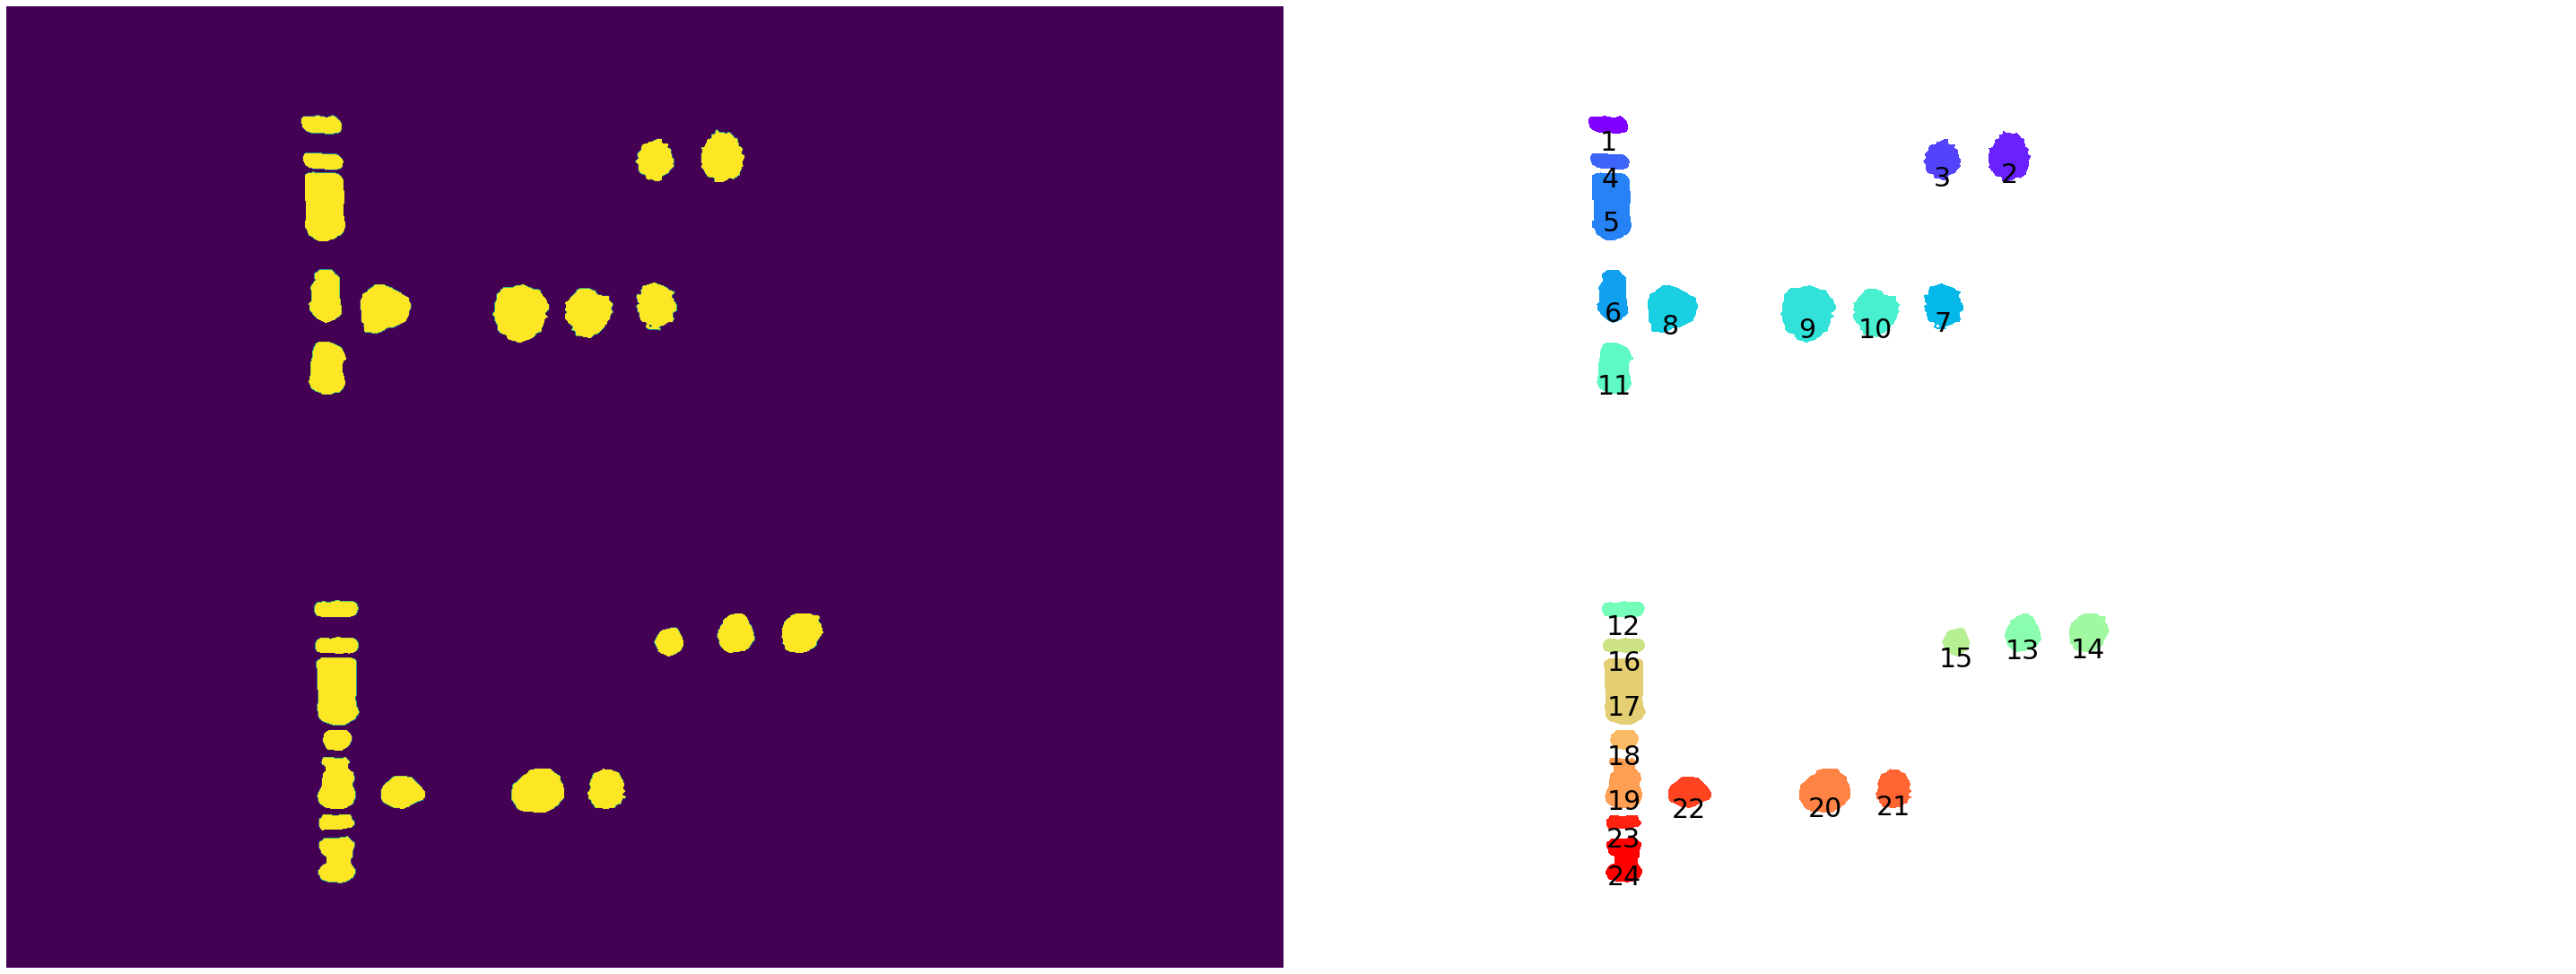

In [41]:
original_image = imageio.imread(original_image_path)

# Converting to desired number of channels
if n_channels == 1:  # Target input: 1 channel
    if original_image.shape[-1] == 3:  # Actual input: 3 channels
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
    elif original_image.shape[-1] == 4: # Actual input: 4 channels
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGBA2GRAY)
    # No change required for already grayscale images
elif n_channels == 3:  # Target input: 3 channels
    if original_image.shaoe[-1] == 4:  # Actual input: 4 channels
        original_image = cv2.cvtColor(original_image, cv2.COLOR_RGBA2RGB)
    elif original_image.shape[-1] != 3:  # Actual input: 1 channels
        original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2RGB)


# Normalizing image
if original_image.dtype == 'uint8':
    max_val = 255
elif original_image.dtype == 'uint16':
    max_val = 65535
original_image = original_image.astype(np.float32) / (max_val - 0)

standard_image_transform = transforms.Compose([transforms.ToTensor()])
original_image_tensor = standard_image_transform(original_image)

original_image_tensor = torch.unsqueeze(original_image_tensor, dim=0)

net = UNet(n_channels=1, n_classes=2, bilinear=False)
net.train()
modelweights = torch.load(f=checkpoint_file_path, map_location=torch.device("cpu"))
net.load_state_dict(state_dict = modelweights)

with torch.no_grad():
    # predict the mask
    mask_pred = net(original_image_tensor)
mask_pred.squeeze()
mask_pred_array = np.transpose(mask_pred.detach().squeeze().cpu().numpy(), (1, 2, 0))  # CHW to HWC
height, width = mask_pred_array.shape[0], mask_pred_array.shape[1]
threshold = 0.8
thresholded = np.zeros((height, width))
for row in range(height):
    for column in range(width):
        if mask_pred_array[row][column][0] < (1-threshold) and mask_pred_array[row][column][1] > threshold:
            thresholded[row][column] = 1



# use a boolean condition to find where pixel values are > 0.75
blobs = thresholded == 1

# label connected regions that satisfy this condition
labels, nlabels = ndimage.label(blobs, structure=[[1,1,1],[1,1,1],[1,1,1]])


# find their centres of mass. in this case I'm weighting by the pixel values in
# `img`, but you could also pass the boolean values in `blobs` to compute the
# unweighted centroids.
r, c = np.vstack(ndimage.center_of_mass(thresholded, labels, np.arange(nlabels) + 1)).T

# find their distances from the top-left corner
d = np.sqrt(r*r + c*c)


# Get coordinates for each unique band
# create array of intensities
volume_labels = np.zeros((nlabels+1), float)
area_labels = np.zeros((nlabels+1), int)

for h in range(height):
    for w in range(width):
        volume_labels[labels[h][w]] += original_image[h][w]  # index = label, value += intensity(between 0 and 1)
        area_labels[labels[h][w]] += 1
print(f'(nlabels = {nlabels})\nvolume_labels: {volume_labels}')

# plot
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(40, 40))
ax[0].imshow(thresholded)
ax[1].imshow(np.ma.masked_array(labels, ~blobs), cmap=plt.cm.rainbow)
for ri, ci, di in zip(r, c, d):
#     ax[1].annotate('', xy=(0, 0), xytext=(ci, ri),
#                    arrowprops={'arrowstyle':'<-', 'shrinkA':0})
#     ax[1].annotate(f'label={label}, concentration={volume_labels[label]}', xy=(ci, ri),  xytext=(0, -5),
#     textcoords='offset points', ha='center', va='top',
    label = int(labels[int(ri)][int(ci)])
    ax[1].annotate(f'{label}', xy=(ci, ri),  xytext=(0, -5),
               textcoords='offset points', ha='center', va='top',
               fontsize=30)
for aa in ax.flat:
    aa.set_axis_off()
fig.tight_layout()
plt.savefig('C:/Users/s2137314/Downloads/save as pdf.pdf')
plt.show()

In [36]:
real_volumes = []
analyzer_volumes = []
measured_volumes = volume_labels[1:]

24

In [ ]:
measured_ratios = []
real_ratios = []
analyzer_ratios = []
real_volumes = [42, 50, 42, 33, 125, 48, 36, 42, 42]
measured_volumes = volume_labels[1:]
analyzer_volumes = [651, 847, 741, 585, 1885, 757, 564, 550, 471]
base_value_real = 33
base_value_measured = 155
base_value_analyzer = 585

for r, m, a in zip(real_volumes, measured_volumes, analyzer_volumes):
    real_ratios.append(r/base_value_real)
    measured_ratios.append(m/base_value_measured)
    analyzer_ratios.append(a/base_value_analyzer)
print("Real // Measured // GelAnalyzer")
print(np.c_[real_ratios, measured_ratios, analyzer_ratios])
x = range(1,10)
plt.plot(x, real_ratios, color='black')
plt.plot(x, measured_ratios, color='red')
plt.plot(x, analyzer_ratios, color='blue')
plt.legend()
